## VanCrime visualizations
Using cleaned data from cleaningdata_vancrime notebook.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import geopandas as geo

from mpl_toolkits.mplot3d import Axes3D


Mapping the crime stats by neighborhod, In total and then by year

In [49]:
crime_yearly = pd.read_pickle('crime_countbyyear.pkl') 
pd.set_option("display.max_rows", None) #must enable scrolling, otherwise comment this line out and use crime_yearly.head()
crime_yearly

crime_type,neighbourhood,year,BnE Commercial,BnE Residential,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,Arbutus Ridge,2003,33,140,1,90,22,134,171,10,91,0,9
1,Arbutus Ridge,2004,30,142,0,113,18,102,193,10,106,1,2
2,Arbutus Ridge,2005,28,120,0,107,21,80,216,7,76,0,5
3,Arbutus Ridge,2006,26,131,0,87,27,93,105,9,37,0,3
4,Arbutus Ridge,2007,32,104,0,70,26,78,77,8,39,0,2
5,Arbutus Ridge,2008,21,119,0,58,28,87,67,7,26,1,4
6,Arbutus Ridge,2009,24,125,0,58,23,95,76,5,26,2,2
7,Arbutus Ridge,2010,17,122,0,46,19,76,60,9,17,0,1
8,Arbutus Ridge,2011,10,108,0,43,8,57,93,7,9,0,2
9,Arbutus Ridge,2012,14,107,0,34,11,68,122,9,13,0,4


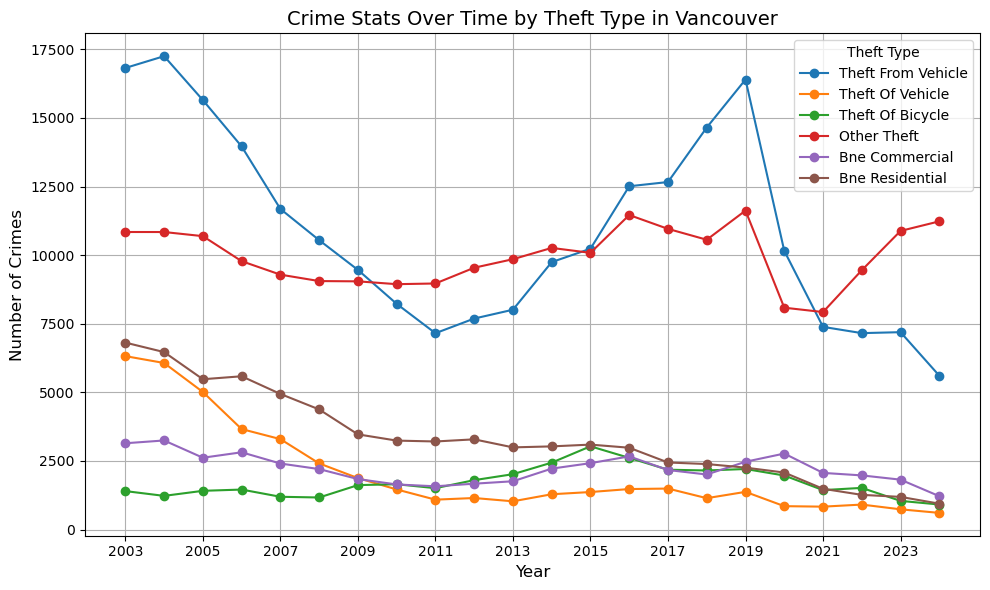

In [44]:
theft_columns = ['Theft from Vehicle', 'Theft of Vehicle', 'Theft of Bicycle', 'Other Theft','BnE Commercial','BnE Residential']

# Group by 'year' and sum each theft type
crime_by_year = crime_yearly.groupby('year')[theft_columns].sum().reset_index()

plt.figure(figsize=(10, 6))

for theft_type in theft_columns:
    plt.plot(crime_by_year['year'], crime_by_year[theft_type], marker='o', linestyle='-', label=theft_type.replace('_', ' ').title())

years = crime_by_year['year'] 
plt.xticks(np.arange(min(years), max(years) + 1, 2))  

plt.title("Crime Stats Over Time by Theft Type in Vancouver", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)
plt.legend(title="Theft Type", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Step 6: Show the plot
plt.show()


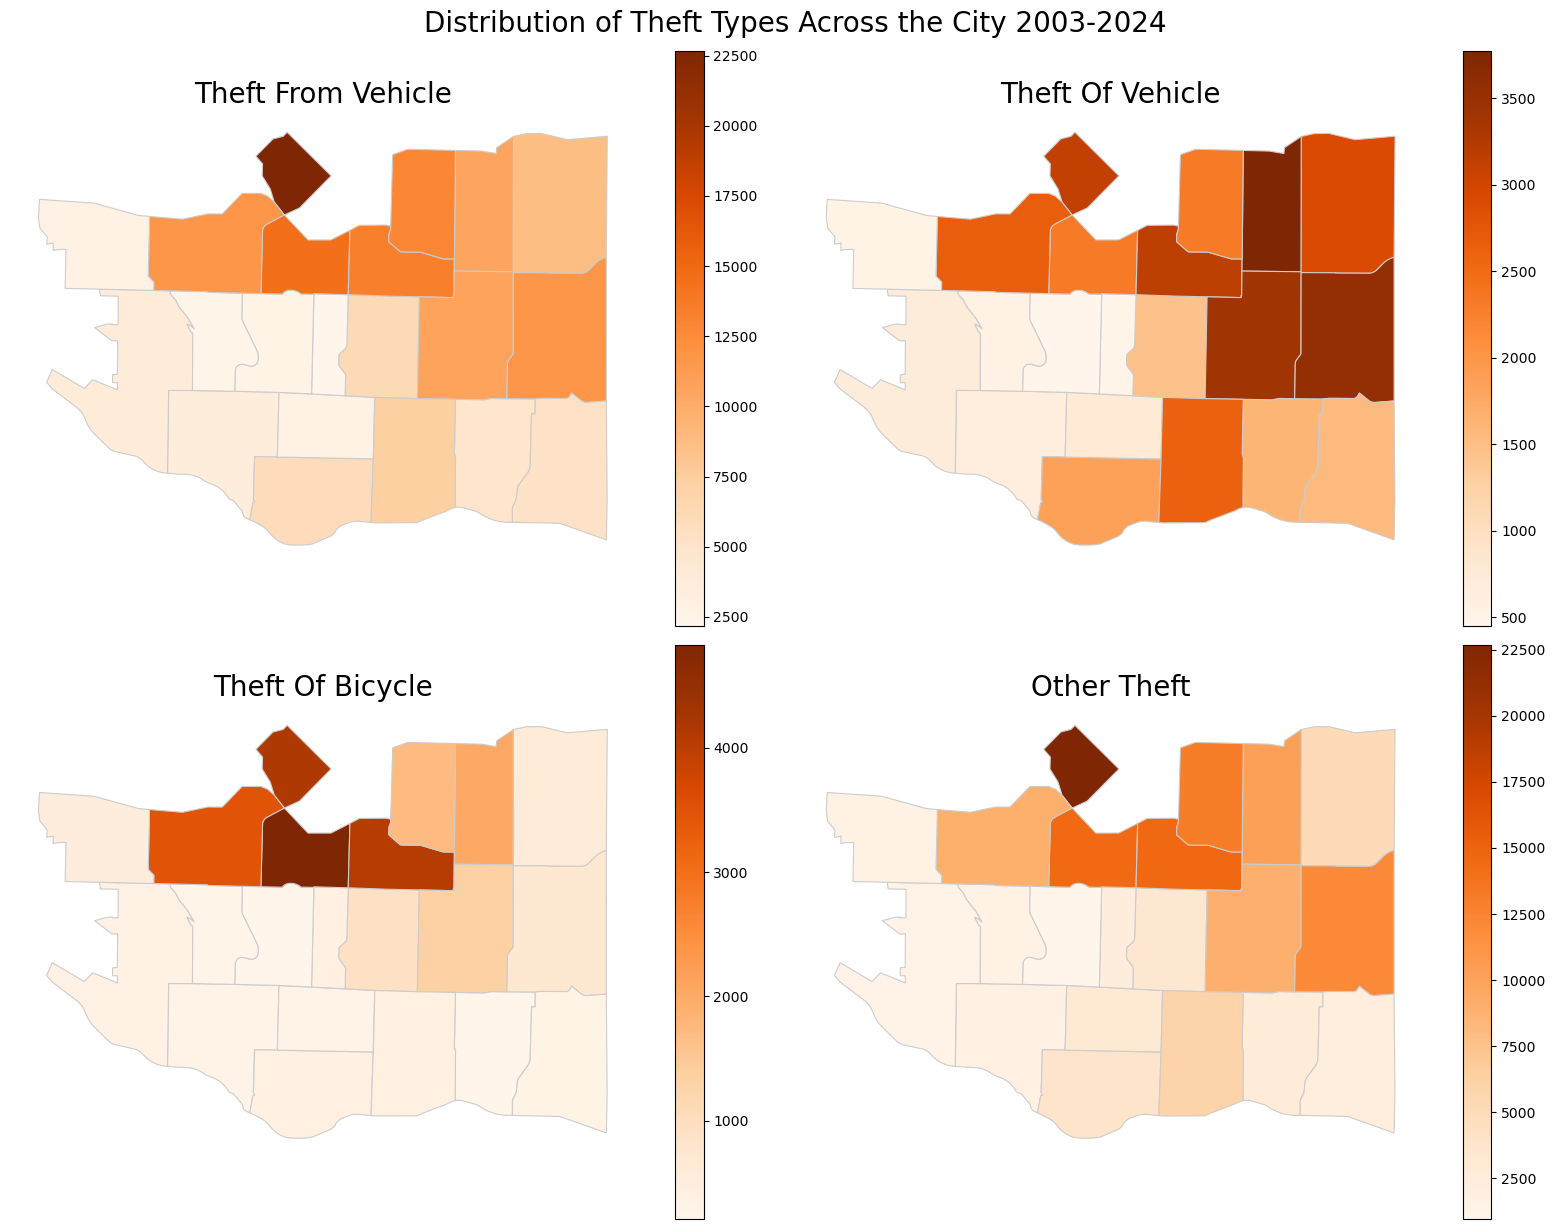

In [59]:
geojson = geo.read_file("local-area-boundary.geojson")  #neighborhood shapes

geojson = geojson.rename(columns={'name': 'neighbourhood'}) 
theft_types = ['Theft from Vehicle', 'Theft of Vehicle', 'Theft of Bicycle', 'Other Theft']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  
axes = axes.flatten()  

# for loop to plot each theft type on a separate map
for i, theft_type in enumerate(theft_types):
    theft_data = crime_yearly.groupby('neighbourhood')[theft_type].sum().reset_index()
    # Merge the GeoJSON file with theft data
    merged_data = geojson.merge(theft_data, on='neighbourhood', how='left')  
    merged_data.plot(column=theft_type, cmap='Oranges', linewidth=0.8, edgecolor='0.8', legend=True, ax=axes[i])
    
    axes[i].set_title(f"{theft_type.title()}", fontsize=20) 
    axes[i].axis('off')  # for clean look

plt.tight_layout()
plt.suptitle("Distribution of Theft Types Across the City 2003-2024", fontsize=20, y=1.02)
plt.show()

## Now with a slider to vizualize over time

In [12]:
import dash
from dash import dcc, html, Input, Output
import json
from dash import jupyter_dash

jupyter_dash.default_mode="external"

geojson = geo.read_file("local-area-boundary.geojson")  #neighborhood shapes
geojson = geojson.rename(columns={'name': 'neighbourhood'}) 

# Dash app initialization
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Crime Data by Neighborhood"),
    dcc.Slider(
        id='year-slider', min=crime_yearly['year'].min(), max=crime_yearly['year'].max(),
        value=crime_yearly['year'].min(), 
        marks={str(year): str(year) for year in crime_yearly['year'].unique()},\
        step=None), dcc.Graph(id='crime-map')
])

# update map based on year
@app.callback(
    Output('crime-map', 'figure'),
    [Input('year-slider', 'value')]
)
def update_map(selected_year):
    filtered_data = crime_yearly[crime_yearly['year'] == selected_year]

    # Create the choropleth map
    fig = px.choropleth( filtered_data, geojson=geojson, locations="neighborhood",
        featureidkey="geojson.neighborhood",  # Adjust this key to match your GeoJSON
        color="Theft Of Bicycle",  # Adjust this to the relevant column
        hover_name="neighborhood",
        title=f"Total Crimes in {selected_year}",
        color_continuous_scale="YlOrRd"
    )

    fig.update_geos(fitbounds="locations", visible=False)
    return fig

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[12], line 32, in update_map(selected_year=2003)
     29 filtered_data = crime_yearly[crime_yearly['year'] == selected_year]
     31 # Create the choropleth map
---> 32 fig = px.choropleth( filtered_data, geojson=geojson, locations="neighborhood",
        filtered_data = crime_type              neighbourhood  year  BnE Commercial  BnE Residential  \
0                       Arbutus Ridge  2003              33              140   
22          Central Business District  2003             761              384   
44                  Dunbar-Southlands  2003              46              173   
66                           Fairview  2003             317              572   
88                 Grandview-Woodland  2003             262              653   
110                  Hastings-Sunrise  2003   

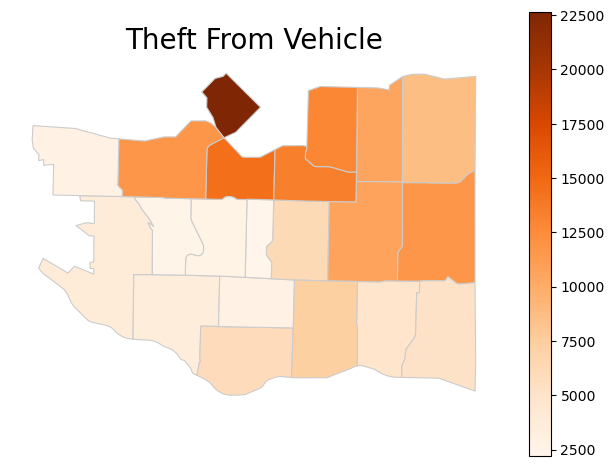

In [74]:
geojson = geo.read_file("local-area-boundary.geojson") 
geojson = geojson.rename(columns={'name': 'neighbourhood'}) 
theft_types = ['Theft from Vehicle']

fig, axes = plt.subplots()  
# for loop to plot each theft type on a separate map
for i, theft_type in enumerate(theft_types):
    theft_data = crime_yearly.groupby('neighbourhood')[theft_type].sum().reset_index()
    # Merge the GeoJSON file with theft data
    merged_data = geojson.merge(theft_data, on='neighbourhood', how='left')  
    merged_data.plot(column=theft_type, cmap='Oranges', linewidth=0.8, edgecolor='0.8', legend=True, ax=axes)
    
    axes.set_title(f"{theft_type.title()}", fontsize=20) 
    axes.axis('off')  # for clean look

plt.tight_layout()
#plt.suptitle("Distribution of Theft Types Across the City 2003-2024", fontsize=20, y=1.02)
plt.show()

In [71]:
theft_data.head()

crime_type,index,neighbourhood,year,BnE Commercial,BnE Residential,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,0,Arbutus Ridge,2003,33,140,1,90,22,134,171,10,91,0,9
1,1,Arbutus Ridge,2004,30,142,0,113,18,102,193,10,106,1,2
2,2,Arbutus Ridge,2005,28,120,0,107,21,80,216,7,76,0,5
3,3,Arbutus Ridge,2006,26,131,0,87,27,93,105,9,37,0,3
4,4,Arbutus Ridge,2007,32,104,0,70,26,78,77,8,39,0,2


##### 